# Explore tracking for a sample session

Validate LED tracking data by visualization, both in terms of positional accuracy and synchronization quality. Note synchronization quality is best checked for frames at the end of the session when lag has had a chance to affect.
        - 

In [1]:
%matplotlib widget

from pathlib import Path
import sys

from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Load environmental variables
repo_path = Path.cwd().parent.parent.parent

load_dotenv()
load_dotenv(dotenv_path = repo_path/'.env')

sys.path.insert(0, str(repo_path))
from lib import utils

sys.path.insert(0, str(Path.cwd().parent))      # from Methods.video_tracking...
import loading as vload
import transform as vtran
import plotting as vplot

## Example session tracked with DeepLabCut

Include an optional debugging time-window to look at data at fine resolution and understand any problems with the alignment of trials with tracking data

In [2]:
# Settings for this example 
# (Note: this is a block where every trial should be visual or audiovisual and so we should be able to see all stimuli)
ferret = 1613
fname = 'Ariel'
block = 'J4-13'         

dlc_threshold = 0.6         # likelihood threshold
center_point = (335, 240)

# Paths to data
data_dir = Path(os.getenv("local_home")) / 'Task_Switching'

spike_path = data_dir / 'spike_times_220606_1808.hdf5'
sensor_path = data_dir / 'sensor_ev220801_1230.hdf5'

tracking_file = data_dir / 'head_tracking/synced_LEDs' / f"F{ferret}_Block_{block}.csv"
video_file = data_dir / 'videos' / f"F{ferret}_{fname}_Block_{block}_Vid0.avi"

In [3]:
# Load tracking data with times (should be close to tdt clock, but that's what we're here to find out)
LEDs = pd.read_csv(tracking_file)
LEDs.head(3)

,frame,red_LEDx,red_LEDy,red_LEDlikelihood,blue_LEDx,blue_LEDy,blue_LEDlikelihood,trial,time
0,0,535.321228,279.954559,1.0,547.657227,275.498749,1.0,0,0.000000
1,1,534.459473,283.743896,1.0,546.366028,278.545593,1.0,0,0.033351
2,2,532.812073,287.835236,1.0,544.046936,281.387665,1.0,0,0.066702


In [4]:
# Load sensor data (times are relative to tdt clock)
sensor_ev = vload.load_sensor_data(sensor_path, ferret=f"F{ferret}_{fname}", block=f"Block_{block}")

## Data transformation

Do some preprocessing to get rid of noise in LED tracking signal

In [5]:
LEDs = vtran.filter_for_low_likelihoods(LEDs, threshold=dlc_threshold)
LEDs = vtran.interpolate_missing_frames(LEDs, nframes=20)
LEDs = vtran.compute_head_pose(LEDs, method='unweighted')
# df = vtran.add_smoothing(df, width=5)
LEDs = vtran.compute_speed(LEDs, window=-8)

In [6]:
def get_event_frame(event_timestamps:np.array, trials:pd.DataFrame):
    """ 
    Estimate the video frame in which an event occurs

    Args:
        event_timestamps: array of event timestamps (according to tdt clock)
        LEDs: dataframe containing frame times (now according to tdt clock) 

    Returns:
        event_frame: closest video frame to timestamp
    """

    event_frames = [LEDs.loc[LEDs[LEDs['time']< t].index, 'frame'].max() for t in event_timestamps]

    return np.array(event_frames)

In [7]:
# Convert onset times into frames and trials
sensor_ev['onset_frame'] = get_event_frame(sensor_ev['onsets'], LEDs[['time','frame']])
sensor_ev['offset_frame'] = get_event_frame(sensor_ev['offsets'], LEDs[['time','frame']])

sensor_ev = pd.DataFrame(sensor_ev)
sensor_ev.tail(3)

,onsets,offsets,chan,onset_frame,offset_frame
771,2069.911756,2070.510592,3,62083,62101
772,2070.551142,2072.629043,3,62102,62164
773,2074.307379,2075.444838,3,62215,62249


In [8]:
# Preassign zero array
n_frames, sensor_chans = LEDs.shape[0], sensor_ev.chan.max()+1
sensor_arr = np.zeros((n_frames, sensor_chans))

# Make array values = 1 when sensor on relevant channel is high
for _, ev in sensor_ev.iterrows():
    sensor_arr[int(ev.onset_frame) : int(ev.offset_frame), int(ev.chan)] = 1

# Create dataframe from array
sensors = pd.DataFrame(sensor_arr, columns=[f"sens{s}" for s in range(0, sensor_chans)])
sensors.index.rename('frame', inplace=True)
sensors = sensors.join(LEDs[['time','frame']], on='frame')
sensors.head(3)

,sens0,sens1,sens2,sens3,time,frame
frame,,,,,,
0,0.0,0.0,0.0,0.0,0.000000,0
1,0.0,0.0,0.0,0.0,0.033351,1
2,0.0,0.0,0.0,0.0,0.066702,2


In [9]:
# Get head position only when the sensors are active 
sensors_long = pd.melt(
    sensors.drop(columns=['time']), 
    id_vars='frame', 
    var_name='sensor'
)
sensors_long['sensor'] = sensors_long['sensor'].str.replace('sens','').astype(int)

active_sensors = sensors_long[sensors_long.value > 0.0]
print(f"Sensors active on {active_sensors.shape[0]} of {LEDs.shape[0]} frames")

# Check for sensors that are co-active
if active_sensors.shape[0] != active_sensors.drop_duplicates().shape[0]:
    print('Senor co-activity detected')

Sensors active on 37034 of 63251 frames


In [10]:
# Combine with tracking data
head_position_on_sensors = pd.merge( 
    active_sensors, 
    LEDs[['frame','head_x','head_y','time']],
    left_on ='frame',
    right_on = 'frame'
    )

head_position_on_sensors.head(3)

,frame,sensor,value,head_x,head_y,time
0,77,0,1.0,317.522339,240.212761,2.568010
1,78,0,1.0,317.447281,240.207039,2.601361
2,80,0,1.0,318.817795,238.727539,2.668062


## Plotting

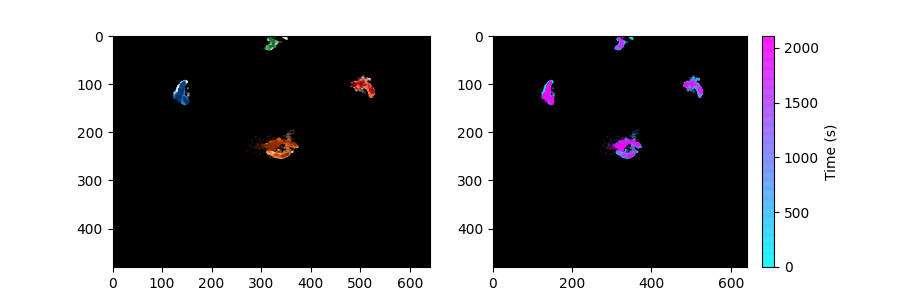

In [11]:
# Plot positions of head for each sensor, with separate color maps for each sensor
fig, axs = plt.subplots(1,2, **{'figsize':(9,3)})

cmaps = ['Oranges','Reds','Blues','Greens']
settings = {'vmin':0, 'vmax':LEDs['time'].max(), 's':0.1, 'alpha':0.3}

for sensor_idx, sensor_data in head_position_on_sensors.groupby('sensor'):

    scatobj = axs[0].scatter(
        x = sensor_data['head_x'].to_numpy(),
        y = sensor_data['head_y'].to_numpy(),
        c = sensor_data['time'].to_numpy(),
        cmap = cmaps[sensor_idx],
        **settings
    )

# Plot with same color scheme
scatobj = axs[1].scatter(
    x = head_position_on_sensors['head_x'].to_numpy(),
    y = head_position_on_sensors['head_y'].to_numpy(),
    c = head_position_on_sensors['time'].to_numpy(),
    cmap = 'cool',
    **settings
)

# Axis formatting
for ax in axs:
    ax.set_ylim([0, 480])
    ax.set_xlim([0, 640])
    ax.invert_yaxis()
    ax.set_facecolor('k')

cbar = plt.colorbar(scatobj, label='Time (s)')
cbar.solids.set_edgecolor("face")
plt.show()

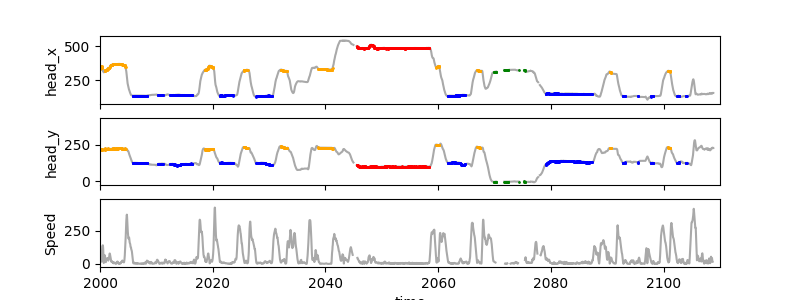

In [20]:
fig, axs = plt.subplots(3,1, sharex=True, **{'figsize':(8, 3)})

plot_time = (2000, 2110)
sensor_colors = ['orange','r','b','g']
settings = {'zorder':0, 'c':'darkgrey', 'legend':False}

LEDs.plot(x='time', y='head_x', ax=axs[0], **settings)
LEDs.plot(x='time', y='head_y', ax=axs[1], **settings)
LEDs.plot(x='time', y='speed', ax=axs[2], **settings)

for sensor, sens_data in head_position_on_sensors.groupby('sensor'):
    sens_data.plot.scatter(x='time', y='head_x', ax=axs[0], s=1, c=sensor_colors[sensor])
    sens_data.plot.scatter(x='time', y='head_y', ax=axs[1], s=1, c=sensor_colors[sensor])

axs[2].set_xlim(plot_time)
axs[2].set_ylabel('Speed')

plt.show()

In [ ]:
vf = vplot.video_figure(
    video_file = str(video_file),
    start_time = 2000,
    duration = 100
    )

vf.add_LEDs(LEDs[['frame','time','head_x','head_y','speed']])
vf.add_Sensors(sensors)

vf.run()